In [2]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

from sklearn.metrics import *
import scikitplot as skplt

from functools import partial
import albumentations as A
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE
data = pd.read_csv(r'C:\Users\Наргис\AppData\Local\Programs\Python\Python310\Scripts\data\BOOBS\ICIAR2018_BACH_Challenge\Photos\microscopy_ground_truth.csv', sep=',', 
                  names=["name", "status"])
img_dir = r'C:\Users\Наргис\AppData\Local\Programs\Python\Python310\Scripts\data\BOOBS\ICIAR2018_BACH_Challenge\Photos\phot'
class_names = ['benign', 'normal','invasive']

C:\Users\Наргис\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
data.head()

,name,status
0,name,status
1,n001.tif,Normal
2,n002.tif,Normal
3,n003.tif,Normal
4,n004.tif,Normal


In [6]:
print('Count of Benign    : ', data[data.status == 'Benign'].count())
print('Count of Invasive : ', data[data.status == 'Invasive'].count())
print('Count of Normal : ', data[data.status == 'Normal'].count())

Count of Benign    :  name      100
status    100
dtype: int64
Count of Invasive :  name      100
status    100
dtype: int64
Count of Normal :  name      100
status    100
dtype: int64


Training set
Invasive    74
Benign      71
Normal      69
InSitu      63
Name: status, dtype: int64

Validation set
InSitu      23
Normal      18
Benign      16
Invasive    12
Name: status, dtype: int64

Test set
 status     15
Benign      15
InSitu      15
Invasive    15
Normal      15
Name: status, dtype: int64


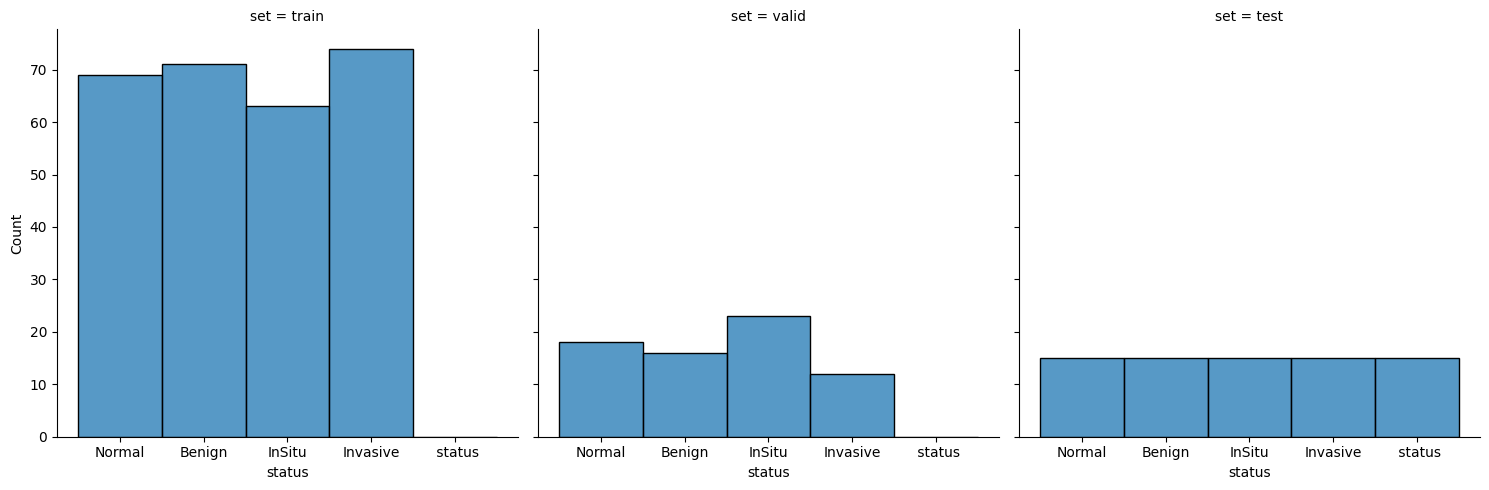

In [7]:
test_df = data.groupby('status').sample(n=15, replace = True)
train_df = data.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# split training and validation set
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df['set'] = 'test'
train_df['set'] = 'train'
valid_df['set'] = 'valid'
data_new = pd.concat([train_df,valid_df, test_df])

ax = sns.displot(data=data_new, x='status', col='set')

print('Training set')
print(train_df.status.value_counts())

print('\nValidation set')
print(valid_df.status.value_counts())

print('\nTest set')
print(test_df.status.value_counts())

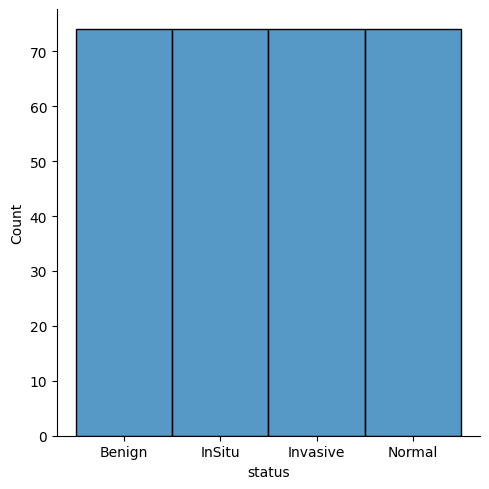

In [10]:
max_count = np.max(train_df.status.value_counts())
min_count = np.min(train_df.status.value_counts())
train_df = train_df.groupby('status').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.status.value_counts()

ax = sns.displot(data=train_df, x='status')

In [14]:
model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}
model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}


In [15]:
model_name = 'efficientnetv2-b0'
model_handle = model_handle_map.get(model_name)
IMAGE_SIZE = model_image_size_map.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_df)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size 224


In [16]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.status_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.status_int))

train_ds = (
    train_loader.shuffle(len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)
valid_ds = (
    valid_loader.shuffle(len(valid_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

AttributeError: 'DataFrame' object has no attribute 'path'

In [ ]:
view_image(train_ds)

In [ ]:
tf.keras.backend.clear_session()
model = build_network(IMAGE_SIZE)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=2e-1,  maximal_learning_rate=7e-3, 
    step_size=3*(SAMPLE_SIZE//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler) , 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
)

history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [checkpoint_cb],
    validation_data=valid_ds,
)
training_history(history.history)

In [ ]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False)

In [ ]:
prediction_df = pd.DataFrame({'filename':test_df.filename.values,'actual':test_df.label.values, 'prediction': np.squeeze(pred_label),'path':test_df.path.values,})
wrong_df = prediction_df[prediction_df.actual != prediction_df.prediction].reset_index(drop=True)

#view first 30 prediction
view_prediction()

In [ ]:
view_wrong_prediction(wrong_df)